## 라이브러리 및 함수 추가

In [15]:
%pip install nbformat

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from koreanHateSpeechDataset import KoreanHateSpeechDataset
from text_cleaning import cleaning_text


## 데이터 불러오기


In [3]:
# 주 데이터셋 불러오기
file_path = "/jf-training-home/NLP_Model/datasets_rw/input/korean_hate_speech.tsv"

koreanHateData = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')

## 레이블 인코딩

In [4]:
hateLabelMap = {'none': 0, 'hate': 1, 'offensive': 1}
koreanHateData['hate'] = koreanHateData['hate'].map(hateLabelMap)

## 텍스트 전처리

In [5]:
koreanHateData['comments'] = koreanHateData['comments'].apply(cleaning_text)


## 훈련 및 테스트 데이터 분할

In [6]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    koreanHateData['comments'].tolist(), koreanHateData['hate'].tolist(), test_size=0.2, random_state=42
)

## 토큰화

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


train_encodings = tokenizer.batch_encode_plus(
    train_texts, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_tensors='pt'
)
test_encodings = tokenizer.batch_encode_plus(
    test_texts, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_tensors='pt'
)

## 데이터셋 및 데이터 로더 생성

In [8]:
# 데이터셋 생성
train_dataset = KoreanHateSpeechDataset(train_encodings, train_labels)
test_dataset = KoreanHateSpeechDataset(test_encodings, test_labels)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## 모델, 옵티마이저, 손실 함수 정의 및 평가 함수


In [9]:
# 모델 정의
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 옵티마이저 및 손실 함수 정의
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

## 훈련 루프

Epoch 1/10:   0%|          | 0/99 [00:00<?, ?it/s]/jf-training-home/NLP_Model/src/models/train/koreanHateSpeechDataset.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}


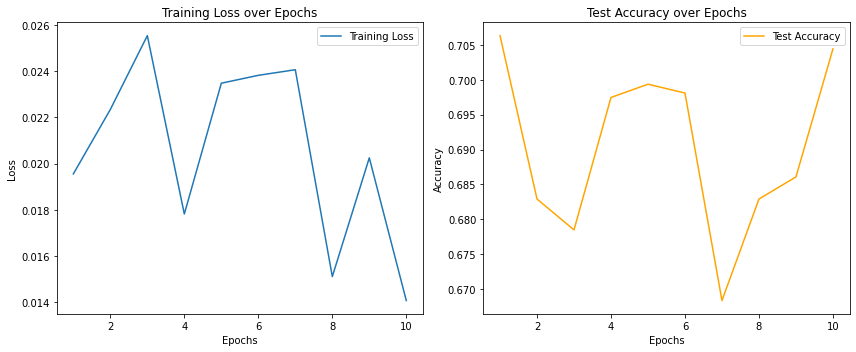

In [16]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from evaluate import evaluate
import torch

num_epochs = 10
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(model.device)
        labels = batch['labels'].to(model.device)
        optimizer.zero_grad()
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / len(train_loader))

    avg_loss = total_loss / len(train_loader)
    test_accuracy = evaluate(model, test_loader)
    accuracies.append(test_accuracy)
    losses.append(avg_loss)

# Plotting the loss and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
